In [1]:
print("hello")

hello


### We intend to build a recommendation system to increase the quality of products and ads that we show to customers , to do so we based our data on a dataset of the UK's retailers , we want to transform that data into a customer centric dataset to segmentate customers into different clusters 

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [3]:
# this is so we can use plotly localy in our notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
# Overwrite some style properties for Seaborn plots
sns.set_theme(rc={'axes.facecolor': '#7df9ff'}, style='darkgrid')

In [5]:
# Let's load the data
df = pd.read_csv("data.csv" , encoding="ISO-8859-1")
df_origin = df
# see what the data looks like 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
# see what the .csv file contains (columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### As we can see here there are 7 colums 
There is a total of 541909 entries and as you might have noticed , we have some missing data in some columns like CustomerID and Description 

In [7]:
# To further understand the data we will need to get more infor about it 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


#### As you can see we have a second problem : illogical values
- This can be observed by the fact the the min in both quatity and UnitPrice are negative  :'(
- This is the case of outliyers as shown by the 75% and 25% precentiles

In [8]:
# this includes the other feilds and the top most repeated words in each of them 
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


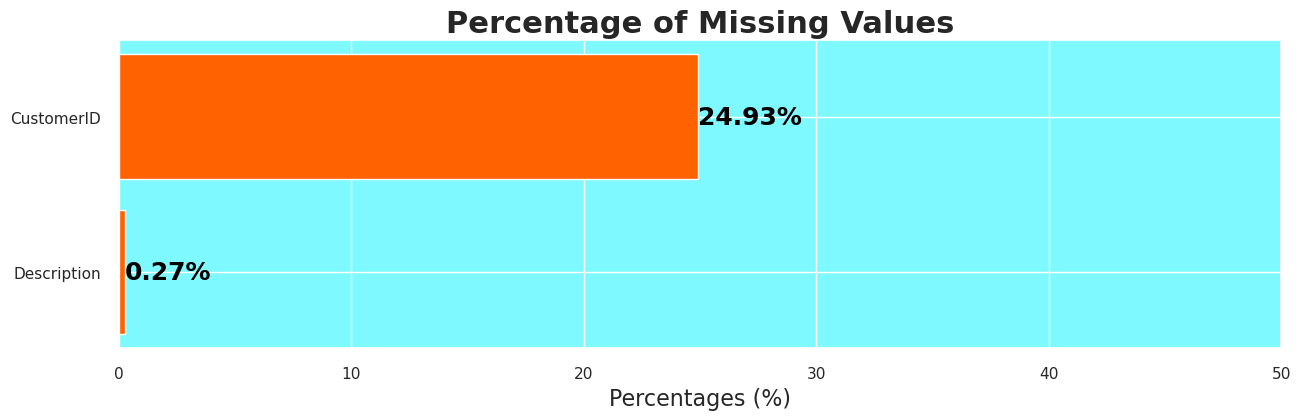

In [9]:
# calculating the mising data
missing_data = df.isnull().sum() # sums each colum seperatly
# give the percentage for each column
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100 # shapes the dataset to line-col (only lines in this case)
#                                                                      ^ forgot to multiply bruh

print(missing_data)
# Srting the vales so they are better presented 
missing_percentage.sort_values(ascending=True, inplace=True)

# Ploting 
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 50])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()





#### the imediate issue is that there is a quarter of customers data missing which is huuuge , and to avoid any bias here the most optimal solution is remove them and see how the data will behave 

#### while de Description data colums despite there being 1400~ values missing , it's nothing compared to the whole set as shown by the percentage

#### there are also inconsistencies we have to keep in mind as shown by the min and max values above 

- seeing the low precentage in the Description column it's better theoretically to remove these and potentially have a cleaner dataset

In [10]:
# let's remove the missing data from the dataset 
df = df.dropna(subset=['CustomerID', 'Description'])

In [11]:
print(df.isnull().sum())
# no missing data now 
# we can focus on inconsistencies and duplicates rn

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [12]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [13]:
print(f"number of duplacted values is : {df.duplicated().sum()}")

# removing the duplicates
df.drop_duplicates(inplace=True)


number of duplacted values is : 5225


/tmp/ipykernel_28849/3652470560.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# (visualising the precentage of the data left after cleaning so far)
print(f"percentage of data left after cleaning is {(df.shape[0]/df_origin.shape[0])*100:.2f} %")

percentage of data left after cleaning is 74.11 %


In [15]:
# On thing that you might not have noticed is that Invoice despite it being (visually) a number it's not counted as one even after cleaning 
# which might indicate that there are string values somewhere m let's find out 

df.sort_values(['InvoiceNo'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [16]:
# as you can see here , there are values that start with C and negative Quatity which indicates that these are returned elements
# ofc we can't just leave it like like this 

# Filtering out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Let's take the cancelled returned elements/transactions 
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']

# we gonna peek at it now like a sussy little sh-
cancelled_transactions.describe().drop('CustomerID', axis=1)


/tmp/ipykernel_28849/94928120.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000
